In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sentencepiece as spm
import os
import warnings

from tensorflow import keras
from tensorflow.keras.initializers import Constant
from konlpy.tag import Mecab
from collections import Counter

!git clone https://github.com/e9t/nsmc.git
os.listdir('nsmc')

warnings.filterwarnings(action='ignore')

fatal: destination path 'nsmc' already exists and is not an empty directory.


## 데이터 로드

In [2]:
train_data = pd.read_table('nsmc/'+'ratings_train.txt')
test_data = pd.read_table('nsmc/'+'ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 중복값 제거, 결측치 확인

In [3]:
print("학습데이터 총량 :", len(train_data['document']))
print("학습데이터 고유값 :",train_data['document'].nunique())
print("테스트데이터 총량 :", len(test_data['document']))
print("테스트데이터 고유값 :",test_data['document'].nunique())
print("라벨데이터 고유값 :",test_data['label'].nunique()) # label 0: negative / 1: positive

학습데이터 총량 : 150000
학습데이터 고유값 : 146182
테스트데이터 총량 : 50000
테스트데이터 고유값 : 49157
라벨데이터 고유값 : 2


In [4]:
train_data.drop_duplicates(subset=['document'], inplace=True)
print("학습데이터 총량 :", len(train_data['document']))
print("학습데이터 고유값 :",train_data['document'].nunique())

test_data.drop_duplicates(subset=['document'], inplace=True)
print("테스트데이터 고유값 :",test_data['document'].nunique())
print("테스트데이터 총량 :", len(test_data['document']))

학습데이터 총량 : 146183
학습데이터 고유값 : 146182
테스트데이터 고유값 : 49157
테스트데이터 총량 : 49158


In [5]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [6]:
test_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [7]:
train = train_data.dropna(how='any')

In [8]:
test = test_data.dropna(how='any')

In [9]:
train.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [10]:
test.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49157 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49157 non-null  int64 
 1   document  49157 non-null  object
 2   label     49157 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


## 리뷰 문장 길이 확인

In [13]:
doc_len = list(map(lambda x: len(x), train['document']))
doc_len[:4]

[19, 33, 17, 29]

In [14]:
min_len, max_len = min(doc_len), max(doc_len)
min_len, max_len

(1, 146)

In [15]:
sentence_length = np.zeros((max_len), dtype=int)

In [16]:
for sen in train['document']:
    sentence_length[len(sen)-1] += 1

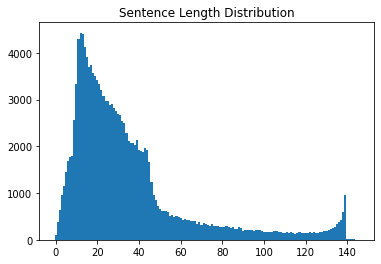

In [17]:
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [18]:
# 가장 긴 문장
list(train[train['document'].apply(lambda x: len(x)==max_len)]['document'])

['"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"',
 '"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"',
 '"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"']

In [19]:
# 가장 짧은 문장
list(train[train['document'].apply(lambda x: len(x)==min_len)]['document'])[:6]

['아', '잼', '1', '4', '굿', '짱']

In [20]:
list(train[train['document'].apply(lambda x: len(x)==2)]['document'])[:4]

['최고', '졸작', '대박', '버려']

In [21]:
doc_len = np.array(doc_len)

print('문장길이 평균 : ', np.mean(doc_len))
print('문장길이 최대 : ', np.max(doc_len))
print('문장길이 표준편차 : ', np.std(doc_len))

# 문장 최대 길이를 평균 + 표준편차*2로 설정한다.
max_sentence = np.mean(doc_len) + 2 * np.std(doc_len)
maxlen = int(max_sentence)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(doc_len < max_sentence) / len(doc_len)))

문장길이 평균 :  35.981338331668745
문장길이 최대 :  146
문장길이 표준편차 :  29.49113203149937
pad_sequences maxlen :  94
전체 문장의 0.9323719746617231%가 maxlen 설정값 이내에 포함됩니다. 


두 글자부터는 어느 정도 호불호를 보여주기 때문에 사용할 데이터에 포함한다. 한 글자의 경우 의미 없는 내용인 경우가 많기 때문에 제거한다. 너무 긴 문장은 제거하기 위해 40을 기준으로 두고 중복값도 제거한다.

In [26]:
min_len_cor = 2
max_len_cor = 40

tr_data = train[train['document'].apply(lambda x: min_len_cor <= len(x) <= max_len_cor)]
tr_data.drop_duplicates(subset=['document'], inplace=True)
tr_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [23]:
ts_data = test[test['document'].apply(lambda x: min_len_cor <= len(x) <= max_len_cor)]
ts_data.drop_duplicates(subset=['document'], inplace=True)
ts_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1
...,...,...,...
49992,1077821,내일 토요일밤 MBC에서 영화 해준다.... 봐야지... 기대,1
49993,5494272,액션영화로 기대하지말고 스릴러영화라 생각하고 보면 괜찮은 영화인듯^^,1
49994,5567676,정말 너무 재밌음 ㅋ,1
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0


In [30]:
corpus = [sen for sen in tr_data['document']]
corpus[:5]

['아 더빙.. 진짜 짜증나네요 목소리',
 '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '원작의 긴장감을 제대로 살려내지못했다.']

In [31]:
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'
vocab_size = 8000

with  open(temp_file, 'w') as f:
    for row in corpus:
        f.write(str(row) + '\n')
        
spm.SentencePieceTrainer.Train('--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size))

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 375831 Mar 24 03:22 korean_spm.model
-rw-r--r-- 1 root root 145189 Mar 24 03:22 korean_spm.vocab


In [32]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1668, 10, 409, 16, 1585, 10, 154, 13, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [33]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        if type(sen) is not str :
            print("is not string : {}".format(sen))
            continue
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [34]:
my_corpus = ['왜 정확도가 이렇게 나오지','뭐가 잘못된 건지 모르겠다', '누가 알려줬으면 좋겠다']
my_tensor, my_word_index, my_index_word = sp_tokenize(s, my_corpus)
print(my_tensor)

[[  47 6204   12   10  150 3300]
 [1458 5922 3360  809    0    0]
 [ 909 4633 7991  289 1603    0]]


In [35]:
tensor, word_index, index_word = sp_tokenize(s, corpus[:5])
print(corpus[0:5])
tensor

['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다', '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정', '원작의 긴장감을 제대로 살려내지못했다.']


array([[  45,  906,    5,   28, 2067,   66, 1777,    0,    0,    0,    0,
           0,    0,    0,    0],
       [1179,    7, 4777,  174, 1161,   29,  265,   40,  163,  507,  369,
        1419, 6316,  686,  372],
       [  22,  451, 7519,  294, 4688,  641, 2265, 1600,  333,    0,    0,
           0,    0,    0,    0],
       [2205,   12,  209,  184, 4323,    3,    5, 5590,  975,   95,    5,
         654, 5833,    0,    0],
       [3146,  712,   14,  671, 3575,  210,   20,  492,  181,    4,    0,
           0,    0,    0,    0]], dtype=int32)

In [36]:
X_train,X_train_word_index, X_train_index_word = sp_tokenize(s, tr_data['document'])
X_test,X_test_word_index, X_test_index_word = sp_tokenize(s, ts_data['document'])

In [37]:
# 현재 list 상태 ==> ndarray로 바꿔주기
y_train = np.array(list(tr_data['label']))
y_test = np.array(list(ts_data['label']))

In [38]:
print("학습데이터 :",len(X_train))
print("타겟데이터 :",len(y_train))

학습데이터 : 104874
타겟데이터 : 104874


In [39]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(train_input[:3])
print(val_input[:3])

[[4976 4976  305   23  180    7  238   10 1996   48  474 1153  241   17
    22  949    4    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [  30 1951   18   51   78  241 1123   11  113  677 1263  704    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 159   38 1199 2517    9 1223   21   18 4960  203 2333    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[2038   65 3849  287  240 4479  462    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [2360 4732 5967   31 4338 3583   11 2726  207 1217   18 1522   11  877
    92    4    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 

In [40]:
vocab_size = 8000    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          128000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 128,881
Trainable params: 128,881
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_basic = model.fit(train_input, train_target, epochs=10, validation_data=(val_input, val_target))

Epoch 1/10
2622/2622 [==============================] - 59s 22ms/step - loss: 0.3268 - accuracy: 0.8605 - val_loss: 0.3500 - val_accuracy: 0.8466
Epoch 2/10
2622/2622 [==============================] - 57s 22ms/step - loss: 0.2943 - accuracy: 0.8729 - val_loss: 0.3535 - val_accuracy: 0.8468
Epoch 3/10
2622/2622 [==============================] - 58s 22ms/step - loss: 0.2693 - accuracy: 0.8815 - val_loss: 0.3772 - val_accuracy: 0.8485
Epoch 4/10
2622/2622 [==============================] - 58s 22ms/step - loss: 0.2482 - accuracy: 0.8883 - val_loss: 0.4043 - val_accuracy: 0.8463
Epoch 5/10
2622/2622 [==============================] - 57s 22ms/step - loss: 0.2308 - accuracy: 0.8938 - val_loss: 0.4090 - val_accuracy: 0.8428
Epoch 6/10
2622/2622 [==============================] - 58s 22ms/step - loss: 0.2161 - accuracy: 0.8987 - val_loss: 0.4235 - val_accuracy: 0.8436
Epoch 7/10
2622/2622 [==============================] - 58s 22ms/step - loss: 0.2008 - accuracy: 0.9031 - val_loss: 0.4636 -

In [47]:
result = model.evaluate(X_test,  y_test, verbose=2)
print(result)

1106/1106 - 5s - loss: 0.5180 - accuracy: 0.8211
[0.5179717540740967, 0.8210883140563965]


In [48]:
my_corpus = ['재밌어요. 추천합니다.']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model.predict(tensor))}")

my_corpus = ['개쓰레기']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model.predict(tensor))}")

my_corpus = ['이딴 거 볼 시간에 다른 거 보세요']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model.predict(tensor))}")

my_corpus = ['정말 별로네요 제 마음의 별로']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model.predict(tensor))}")

재밌어요. 추천합니다.
긍정적인 리뷰일 확률 : 0.9479865431785583
개쓰레기
긍정적인 리뷰일 확률 : 0.18324002623558044
이딴 거 볼 시간에 다른 거 보세요
긍정적인 리뷰일 확률 : 0.010250389575958252
정말 별로네요 제 마음의 별로
긍정적인 리뷰일 확률 : 0.015339791774749756


## Mecab 사용

In [49]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist() #중복 제거
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]   
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train, test, 8000)

In [50]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [51]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [52]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"


In [53]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [54]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [55]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


In [56]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [57]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [58]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 13s 42ms/step - loss: 0.5132 - accuracy: 0.7696 - val_loss: 0.3724 - val_accuracy: 0.8412
Epoch 2/10
266/266 [==============================] - 11s 41ms/step - loss: 0.3477 - accuracy: 0.8546 - val_loss: 0.3443 - val_accuracy: 0.8517
Epoch 3/10
266/266 [==============================] - 11s 40ms/step - loss: 0.3201 - accuracy: 0.8660 - val_loss: 0.3387 - val_accuracy: 0.8543
Epoch 4/10
266/266 [==============================] - 11s 40ms/step - loss: 0.3062 - accuracy: 0.8732 - val_loss: 0.3400 - val_accuracy: 0.8545
Epoch 5/10
266/266 [==============================] - 11s 40ms/step - loss: 0.2957 - accuracy: 0.8777 - val_loss: 0.3404 - val_accuracy: 0.8552
Epoch 6/10
266/266 [==============================] - 11s 41ms/step - loss: 0.2862 - accuracy: 0.8823 - val_loss: 0.3464 - val_accuracy: 0.8533
Epoch 7/10
266/266 [==============================] - 11s 41ms/step - loss: 0.2763 - accuracy: 0.8873 - val_loss: 0.3486 - val_accuracy:

In [59]:
result = model2.evaluate(x_test,  y_test, verbose=2)
print(result)

1537/1537 - 7s - loss: 0.3752 - accuracy: 0.8444
[0.3751542270183563, 0.8443965315818787]


In [60]:
my_corpus = ['재밌어요. 추천합니다.']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model2.predict(tensor))}")

my_corpus = ['개쓰레기']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model2.predict(tensor))}")

my_corpus = ['이딴 거 볼 시간에 다른 거 보세요']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model2.predict(tensor))}")

my_corpus = ['정말 별로네요 제 마음의 별로']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model2.predict(tensor))}")

재밌어요. 추천합니다.
긍정적인 리뷰일 확률 : 0.29685544967651367
개쓰레기
긍정적인 리뷰일 확률 : 0.4468419551849365
이딴 거 볼 시간에 다른 거 보세요
긍정적인 리뷰일 확률 : 0.8276686668395996
정말 별로네요 제 마음의 별로
긍정적인 리뷰일 확률 : 0.08203449845314026


In [61]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.LSTM(8))   
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [62]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_3 = model3.fit(train_input, train_target, epochs=7, validation_data=(val_input, val_target))

Epoch 1/7
2622/2622 [==============================] - 62s 23ms/step - loss: 0.4868 - accuracy: 0.7559 - val_loss: 0.3700 - val_accuracy: 0.8384
Epoch 2/7
2622/2622 [==============================] - 59s 23ms/step - loss: 0.3389 - accuracy: 0.8530 - val_loss: 0.3554 - val_accuracy: 0.8447
Epoch 3/7
2622/2622 [==============================] - 60s 23ms/step - loss: 0.3057 - accuracy: 0.8662 - val_loss: 0.3557 - val_accuracy: 0.8479
Epoch 4/7
2622/2622 [==============================] - 59s 23ms/step - loss: 0.2813 - accuracy: 0.8761 - val_loss: 0.3768 - val_accuracy: 0.8463
Epoch 5/7
2622/2622 [==============================] - 59s 23ms/step - loss: 0.2603 - accuracy: 0.8852 - val_loss: 0.3814 - val_accuracy: 0.8458
Epoch 6/7
2622/2622 [==============================] - 60s 23ms/step - loss: 0.2426 - accuracy: 0.8917 - val_loss: 0.4043 - val_accuracy: 0.8409
Epoch 7/7
2622/2622 [==============================] - 60s 23ms/step - loss: 0.2285 - accuracy: 0.8970 - val_loss: 0.4107 - val_ac

In [65]:
result = model3.evaluate(x_test,  y_test, verbose=2)
print(result)

1537/1537 - 8s - loss: 0.8088 - accuracy: 0.5093
[0.8087736368179321, 0.5093069076538086]


In [64]:
my_corpus = ['재밌어요. 추천합니다.']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model3.predict(tensor))}")

my_corpus = ['개쓰레기']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model3.predict(tensor))}")

my_corpus = ['이딴 거 볼 시간에 다른 거 보세요']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model3.predict(tensor))}")

my_corpus = ['정말 별로네요 제 마음의 별로']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model3.predict(tensor))}")

재밌어요. 추천합니다.
긍정적인 리뷰일 확률 : 0.8517996072769165
개쓰레기
긍정적인 리뷰일 확률 : 0.24405452609062195
이딴 거 볼 시간에 다른 거 보세요
긍정적인 리뷰일 확률 : 0.04297676682472229
정말 별로네요 제 마음의 별로
긍정적인 리뷰일 확률 : 0.15714338421821594


In [69]:
my_corpus = ['진짜 너무 재밌어요']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model2.predict(tensor))}")

my_corpus = ['감독 천재인 듯']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model2.predict(tensor))}")

my_corpus = ['진짜 너무 재미없어요']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model2.predict(tensor))}")

my_corpus = ['이딴 거 만드는 데 쓴 돈이 아깝다']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model2.predict(tensor))}")

my_corpus = ['꼭 보세요 추천해요!']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model2.predict(tensor))}")

my_corpus = ['보지 마세요']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(f"{my_corpus[0]}\n긍정적인 리뷰일 확률 : {float(model2.predict(tensor))}")

진짜 너무 재밌어요
긍정적인 리뷰일 확률 : 0.5823915600776672
감독 천재인 듯
긍정적인 리뷰일 확률 : 0.5060532689094543
진짜 너무 재미없어요
긍정적인 리뷰일 확률 : 0.1647377610206604
이딴 거 만드는 데 쓴 돈이 아깝다
긍정적인 리뷰일 확률 : 0.3770774006843567
꼭 보세요 추천해요!
긍정적인 리뷰일 확률 : 0.5352966785430908
보지 마세요
긍정적인 리뷰일 확률 : 0.44298607110977173


## 회고

loss 값이 고착화되고 학습이 제대로 이루어지지 않는 문제가 있었지만 model.fit부분을 다시 작성하니 제대로 작동되었다. 구체적으로 어떤 문제가 있었던 건진 모르겠어서 관련 자료를 찾아봐야할 거 같다. 

||Model|Model2|Model3|
|:-:|:-:|:-:|:-:|
|정확도|0.8211|0.8444|0.5093|
|재밌어요. 추천합니다.|0.9479865431785583|0.29685544967651367|0.8517996072769165|
|개쓰레기|0.18324002623558044|0.4468419551849365|0.24405452609062195
|이딴 거 볼 시간에 다른 거 보세요|0.010250389575958252|0.8276686668395996|0.04297676682472229
|정말 별로네요 제 마음의 별로|0.015339791774749756|0.08203449845314026|0.15714338421821594

 SentencePiece를 활용했을 때와 Mecab을 이용한 경우 모두 성능이 80퍼센트 이상으로 준수한 결과를 보였다. 하지만 예시 문장을 직접 넣어봤을 땐 SentencePiece를 이용했을 경우엔 언어유희를 사용한 경우 말고는 적합한 결과를 보여줬지만 Mecab을 이용한 모델의 경우는 긍정과 부정을 잘 구분하지 못했다. 모델의 정확도와는 다른 결과를 보여줘 어떤 이유에서 이런 결과가 나온건지 생각해봐야 할 거 같다. 마지막으로 확인해보기 위해 위에 쓴 예시 외에 좀 더 의미가 분명한 문장으로 결과를 확인했더니 비교적 긍, 부정에 대한 확률이 구분되는 것을 볼 수 있었다. 하지만 여전히 그 수치 자체가 확실하게 높거나 낮진 않았다. Model3는 epoch, 단어 수에 변화를 줬는데 정확도가 낮게 나왔다. 그런데 예시 문장으로 결과를 확인했을 땐 Model과 마찬가지로 언어유희 외에는 적합하게 구분해내는 모습을 보였다.